## <a class="anchor" id="part1"></a><b><span style='color:#8bb7cf'>1 |</span><span style='color:#00369c'> Partie 1 - Classification de documents</span></b>  

In [2]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 35.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [88]:
import spacy
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Modèle spacy pour la langue anglaise
nlp = spacy.load("en_core_web_md")

# On tokenise et on obtient les étiquette de la nature de chaque token
def process_data(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    pos_tags = [token.pos_ for token in doc]
    return tokens, pos_tags

print("-----------------JEU ENTRAINEMENT-----------------")
#On ccharge le jeu d'entrainement
jeu_entrainement = pd.read_json("http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/imdb-trn.json")
jeu_entrainement, other_train = train_test_split(jeu_entrainement,test_size=0.995)
#jeu_entrainement = jeu_entrainement.iloc[:5000]

# Paralléliser le traitement des données d'apprentissage
#Pour optimiser le temps de calcul, on peut activer un accélérateur 
#Mais aussi paralléliser avec le package multiprocessing
# https://docs.python.org/fr/3/library/multiprocessing.html
with Pool() as pool:
    jeu_entrainement['tokens'], jeu_entrainement['pos_tags'] = zip(*tqdm(pool.imap(process_data, jeu_entrainement[1]), total=len(jeu_entrainement)))

print(jeu_entrainement.head())

#Idem
print("-----------------JEU TEST-----------------")
jeu_test = pd.read_json("http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/imdb-tst.json")
jeu_test, other_test = train_test_split(jeu_test,test_size=0.995)
#jeu_test = jeu_test.iloc[:5000]

with Pool() as pool:
    jeu_test['tokens'], jeu_test['pos_tags'] = zip(*tqdm(pool.imap(process_data, jeu_test[1]), total=len(jeu_test)))


print(jeu_test.head())

-----------------JEU ENTRAINEMENT-----------------



100%|██████████| 125/125 [00:03<00:00, 40.46it/s]


         0                                                  1  \
6947   pos  On the basis of the preview I'd seen, I went t...   
14347  neg  I gave this movie a single star only because i...   
11911  pos  Exquisite comedy starring Marian Davies (with ...   
9238   pos  The Matador is a witty, dark humored and suspe...   
1329   pos  It is difficult to evaluate this or any other ...   

                                                  tokens  \
6947   [On, the, basis, of, the, preview, I, 'd, seen...   
14347  [I, gave, this, movie, a, single, star, only, ...   
11911  [Exquisite, comedy, starring, Marian, Davies, ...   
9238   [The, Matador, is, a, witty, ,, dark, humored,...   
1329   [It, is, difficult, to, evaluate, this, or, an...   

                                                pos_tags  
6947   [ADP, DET, NOUN, ADP, DET, NOUN, PRON, AUX, VE...  
14347  [PRON, VERB, DET, NOUN, DET, ADJ, NOUN, ADV, S...  
11911  [ADJ, NOUN, VERB, PROPN, PROPN, PUNCT, ADP, DE...  
9238   [DET,


100%|██████████| 125/125 [00:03<00:00, 40.86it/s]


         0                                                  1  \
1201   pos  Not all movies should have that predictable en...   
18703  neg  this movie absolutely terrible ..not only was ...   
4862   pos  This film, for what it was set out to be, succ...   
2376   pos  Marigold is by far the best "outsider's" take ...   
6765   pos  So funny is the perfect way to describe this 1...   

                                                  tokens  \
1201   [Not, all, movies, should, have, that, predict...   
18703  [this, movie, absolutely, terrible, .., not, o...   
4862   [This, film, ,, for, what, it, was, set, out, ...   
2376   [Marigold, is, by, far, the, best, ", outsider...   
6765   [So, funny, is, the, perfect, way, to, describ...   

                                                pos_tags  
1201   [PART, DET, NOUN, AUX, VERB, DET, ADJ, NOUN, S...  
18703  [DET, NOUN, ADV, ADJ, PUNCT, PART, ADV, AUX, D...  
4862   [DET, NOUN, PUNCT, ADP, PRON, PRON, AUX, VERB,...  
2376   [PROP

In [89]:
jeu_test[0].value_counts()

0
pos    67
neg    58
Name: count, dtype: int64

In [90]:
jeu_entrainement[0].value_counts()

0
pos    73
neg    52
Name: count, dtype: int64

In [91]:
#2)
import numpy as np
from tqdm import tqdm

# Fonction pour calculer l'embedding moyen des lemmes des verbes et des adjectifs
def calculate_embedding_mean(tokens, pos_tags):
    verb_adj_lemmas = []
    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag.startswith('VERB') or pos_tag.startswith('ADJ'):
            lemma = nlp(token)[0].lemma_
            verb_adj_lemmas.append(lemma)
    if verb_adj_lemmas:
        embeddings = np.array([nlp(lemma).vector for lemma in verb_adj_lemmas])
        return np.mean(embeddings, axis=0)
    else:
        # Retourne un vecteur nul si aucun verbe ou adjectif trouvé
        return np.zeros(nlp.vocab.vectors_length)

# Fonction pour encoder l'étiquette en un vecteur à deux dimensions
def encode_label(label):
    if label == 'pos':
        return [1, 0]  #sentiment positif
    else:
        return [0, 1]  #sentiment négatif

# On applique les fonctions pour les 2 échantillons entrainement et test
jeu_entrainement['embedding_mean'] = [calculate_embedding_mean(tokens, pos_tags) for tokens, pos_tags in tqdm(zip(jeu_entrainement['tokens'], jeu_entrainement['pos_tags']), total=len(jeu_entrainement))]
jeu_entrainement['label_vector'] = [encode_label(label) for label in tqdm(jeu_entrainement[0])]

jeu_test['embedding_mean'] = [calculate_embedding_mean(tokens, pos_tags) for tokens, pos_tags in tqdm(zip(jeu_test['tokens'], jeu_test['pos_tags']), total=len(jeu_test))]
jeu_test['label_vector'] = [encode_label(label) for label in tqdm(jeu_test[0])]

print(jeu_entrainement.head())
print(jeu_test.head())



100%|██████████| 125/125 [01:01<00:00,  2.04it/s]

100%|██████████| 125/125 [00:00<00:00, 469792.11it/s]

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]

100%|██████████| 125/125 [00:00<00:00, 461521.13it/s]

         0                                                  1  \
6947   pos  On the basis of the preview I'd seen, I went t...   
14347  neg  I gave this movie a single star only because i...   
11911  pos  Exquisite comedy starring Marian Davies (with ...   
9238   pos  The Matador is a witty, dark humored and suspe...   
1329   pos  It is difficult to evaluate this or any other ...   

                                                  tokens  \
6947   [On, the, basis, of, the, preview, I, 'd, seen...   
14347  [I, gave, this, movie, a, single, star, only, ...   
11911  [Exquisite, comedy, starring, Marian, Davies, ...   
9238   [The, Matador, is, a, witty, ,, dark, humored,...   
1329   [It, is, difficult, to, evaluate, this, or, an...   

                                                pos_tags  \
6947   [ADP, DET, NOUN, ADP, DET, NOUN, PRON, AUX, VE...   
14347  [PRON, VERB, DET, NOUN, DET, ADJ, NOUN, ADV, S...   
11911  [ADJ, NOUN, VERB, PROPN, PROPN, PUNCT, ADP, DE...   
9238   [

- On commence à parcourrir les tokens d'une phrase et d'extraire les lemmes des tokens qui sont des verbes ou des adj en utilisant le POS tag. 

- Poru chaque lemme extrait, on ccalcul son vecteur embedding à l'aide du modèle Spacy afin de construire une liste de ces embeddings.

- Enfin, on calcule la moyenne de tous ces embeddings pour obtenir l'embedding moyen des lemmes des verbes et des adjectifs présents dans la phrase.

In [92]:
#3) Créer un dataset test et entrainement

import torch
from torch.utils.data import TensorDataset, DataLoader

#Jeu de données pour les données d'apprentissage
train_embeddings = torch.tensor(jeu_entrainement['embedding_mean'].tolist(), dtype=torch.float32)
train_labels = torch.tensor(jeu_entrainement['label_vector'].tolist(), dtype=torch.float32)
train_dataset = TensorDataset(train_embeddings, train_labels)

#DataLoader pour les données d'apprentissage
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#Idem pour test
test_embeddings = torch.tensor(jeu_test['embedding_mean'].tolist(), dtype=torch.float32)
test_labels = torch.tensor(jeu_test['label_vector'].tolist(), dtype=torch.float32)
test_dataset = TensorDataset(test_embeddings, test_labels)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#On utilise les DataLoader pour itérer sur les données
for embeddings, labels in train_loader:
    # Faites quelque chose avec les embeddings et les labels (par exemple, les utiliser pour l'entraînement d'un modèle)
    print("Embeddings shape:", embeddings.shape)
    print("Labels shape:", labels.shape)
    break  # Sortez de la boucle après le premier lot pour l'exemple


Embeddings shape: torch.Size([32, 300])
Labels shape: torch.Size([32, 2])


In [93]:
#4) Création du dataset de validation en prenant 20% des jeux de données d'entraînement
import tensorflow as tf

# Conversion des données d'entraînement en un objet tf.data.Dataset
train_dataset_tf = tf.data.Dataset.from_tensor_slices((train_embeddings, train_labels))
test_dataset_tf = tf.data.Dataset.from_tensor_slices((test_embeddings, test_labels))

# Calcul du nombre total d'échantillons
total_samples = len(train_dataset_tf)

# Calcul du nombre d'échantillons pour l'entraînement et la validation
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Séparation des jeux de données d'entraînement et de validation
ds_train = train_dataset_tf.take(train_size)
ds_val = train_dataset_tf.skip(train_size)

# Mélange des données d'entraînement et de validation
ds_train_shuffled = ds_train.shuffle(train_size, reshuffle_each_iteration=True)
ds_valid_shuffled = ds_val.shuffle(val_size, reshuffle_each_iteration=True)

# Mise en lots des données d'entraînement et de validation
batch_size = 64
ds_train_batched = ds_train_shuffled.batch(batch_size).prefetch(batch_size).cache()
ds_valid_batched = ds_valid_shuffled.batch(batch_size).prefetch(batch_size).cache()
ds_test_batched = test_dataset_tf.batch(batch_size).prefetch(batch_size).cache()

# Affichage des tailles des ensembles de données
print("Taille de l'ensemble d'entraînement:", train_size)
print("Taille de l'ensemble de validation:", val_size)


Taille de l'ensemble d'entraînement: 100
Taille de l'ensemble de validation: 25


In [94]:
# Itération sur le jeu de données d'entraînement
for batch_data, batch_labels in ds_train_batched:
    # batch_data contient les données d'entraînement pour ce lot
    # batch_labels contient les labels correspondants pour ce lot
    # Vous pouvez traiter batch_data et batch_labels ici selon vos besoins
    # Par exemple, pour afficher les données et les labels de chaque lot :
    print("Données du lot :", batch_data)
    print("Labels du lot :", batch_labels)


Données du lot : tf.Tensor(
[[-0.17071138  0.9921459  -2.020719   ...  1.3166165  -3.2970212
   0.43892145]
 [-1.1613022   0.8000825  -0.80511874 ...  0.5570455  -2.9956722
   0.02778283]
 [-1.1464995   0.61599106 -2.7793553  ...  0.81440026 -2.42284
   0.56790996]
 ...
 [ 0.19068259  3.0468137  -2.330832   ...  2.0551102  -3.2398307
   0.4166162 ]
 [ 0.46256477  1.1912472  -1.9243708  ...  0.6943274  -2.3979664
   0.20879313]
 [-0.77390116  1.4782465  -1.6409242  ... -0.06557429 -2.0840497
   0.878573  ]], shape=(64, 300), dtype=float32)
Labels du lot : tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 

Ce modèle MLP possède 30 302 paramètres. Ce qui reste très raisonnable.

In [95]:
#Afficher la forme du lot d'entrée
for batch in ds_train_batched:
    print("Shape du batch:", batch[0].shape)  # Affiche la forme du lot d'entrée

Shape du batch: (64, 300)
Shape du batch: (36, 300)


In [96]:
#Afficher la forme du lot d'entrée
for batch in ds_valid_batched:
    print("Shape du batch:", batch[0].shape)  # Affiche la forme du lot d'entrée


Shape du batch: (25, 300)


In [102]:
#5) et 6)
import tensorflow as tf
input_shape = 300
num_classes = 2
#Modèle MLP claassique
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)), # Ajoutez input_shape approprié
    tf.keras.layers.Dropout(0.5), #On reprend le dropout de l'énoncé
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Ajoutez num_classes approprié pour la sortie
])

#On utilise le compilateur adam avec la fonction categorical cross-entropy
#Notre variable à prédire sont des commentaires positifs ou néégatifs
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#AArchitecture du modèle et nombre de paramètre
model.summary()


# Entraînement du modèle
training = model.fit(ds_train_batched, epochs=10, validation_data=ds_valid_batched)

# Évaluation du modèle sur les données de validation
loss, accuracy = model.evaluate(ds_valid_batched)
print("Perte sur les données de validation:", loss)
print("Précision sur les données de validation:", accuracy)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               38528     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 2)                 130       
                                                                 
Total params: 46914 (183.26 KB)
Trainable params: 46914 (183.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 136ms/step - loss: 0.9119 - accuracy: 0.5000 - val_loss: 0.6287 - val_accuracy: 0.6000
Epoch 2

In [103]:
print(training.history.keys())
estim_acc = training.history['accuracy']
valid_acc = training.history['val_accuracy']
estim_loss = training.history['loss']
valid_loss = training.history['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


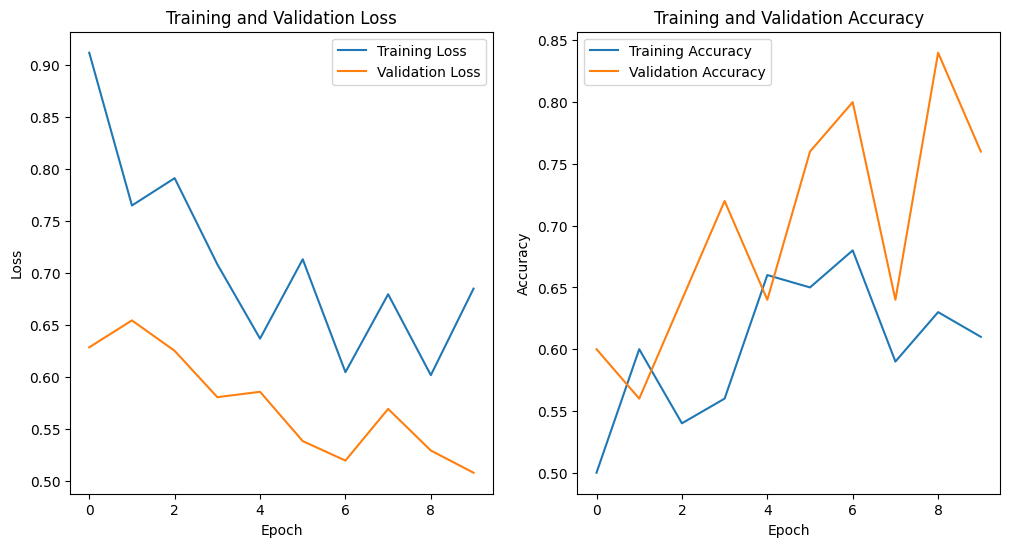

In [104]:
import matplotlib.pyplot as plt

# Visualisation de l'évolution de la perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(estim_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Visualisation de l'évolution de la précision
plt.subplot(1, 2, 2)
plt.plot(estim_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


La plus petite batch_size permet de sauter les vallées de la fonction.
Le learning_rate est ajjusté en le diminuant
momentum : si le changement de direction différe de la direction originale à celle suggéré alors le momentum fait un compromis entre les 2. On peut aussi utiliser la validation early stopping, il revient au modèle qui a donné la validation la plus faible avec u pic le bas de la courbe.
FB avait 8000 TPU pour entrainer leur modèles : 3 semaines d'entrainement . Différents epoch selon les problèmes.

In [100]:
training.history

{'loss': [0.8615254759788513,
  0.8029126524925232,
  0.7912119030952454,
  0.7859246730804443,
  0.6892600059509277,
  0.6614102125167847,
  0.6317368745803833,
  0.49882209300994873,
  0.5401901602745056,
  0.5864728689193726],
 'accuracy': [0.5799999833106995,
  0.6000000238418579,
  0.5799999833106995,
  0.6000000238418579,
  0.6000000238418579,
  0.6700000166893005,
  0.6499999761581421,
  0.7699999809265137,
  0.7400000095367432,
  0.7099999785423279],
 'val_loss': [0.6531179547309875,
  0.602672815322876,
  0.5594421625137329,
  0.55824214220047,
  0.5434125661849976,
  0.527040958404541,
  0.5312052965164185,
  0.5490249991416931,
  0.551860511302948,
  0.5362337827682495],
 'val_accuracy': [0.6000000238418579,
  0.6800000071525574,
  0.6800000071525574,
  0.7200000286102295,
  0.7200000286102295,
  0.7599999904632568,
  0.7599999904632568,
  0.6399999856948853,
  0.6399999856948853,
  0.6399999856948853]}

La perte loss diiminue progressivement au fil des epochs. Cela indique une amélioration continue du modèle MLP dans son ajustement aux données.

L'accuracy tend vers une acc très élevé, ce qui suggère que le modèle a une très bonne capacité à capturer l'information pour détecter les commentaires positifs et négatifs.

On observe le même phénoène sur le jeu de validation et donc le modèle généralise bien à des jeux de données différents.

# Question 7
- Ces variations de performance peuvent s'expliquer par le fait que l'initilisation des poids est généré de manière aléatoire. De ce fait, à chaque fois que nous relançons l'apprentissage, les poids diffèrent d'un entrainement à un autre.

- Dans notre cas, on mélange les données à chaque fois que l'ensemble de données est parcouru (reshuffle_each_iteration=True). Ainsi, chaque epochs aura des données dans des ordres différents (cette technique permet de limiter le risque de sur-apprentissage. 

- Optimisation stochastique: ici on utilise l'optimiseur ADAM qui mets à jour les poids du modèle et qui peut faire varier cette maj d'une éxécution à une autre en raison de la nature de l'algorithme.

In [105]:
#8)
model.evaluate(ds_test_batched)
out = model.predict(ds_test_batched)

2/2 [==============================] - 0s 3ms/step


Obtient-on la même précision ? (répondre quand on aura fait sur les 25 000 données)

# Question 9
Voir les exemples qui ne sont pas bien prédit

## <a class="anchor" id="part1"></a><b><span style='color:#8bb7cf'>2 |</span><span style='color:#00369c'> Partie 2 - LSTM avec apprentissage de représentation</span></b>  